# 1. 🚀 XGBoost — Complete walkthrough
**What you'll get in this notebook**
- Mathematical objective and Taylor expansion used by XGBoost (with equations).
- Step-by-step algorithm explanation.
- Example using the `xgboost` sklearn-style API (`XGBClassifier`) with data, training, and visualizations.
- A from-scratch `SimpleXGB` class that implements the **second-order** update idea (pseudo-Newton) using `DecisionTreeRegressor`.
- Training, evaluation, and comparison examples.
- Visualizations: loss curve, ROC, feature importance, and a single tree plot.

> Notebook style: cell-by-cell, numbered, markdown decorated with emojis and headings for readability.


# 2. ✨ Intuition — what is XGBoost?
- XGBoost = **eXtreme Gradient Boosting**: an optimized implementation of gradient boosted decision trees (GBDT).
- Goals:
  - Use gradient boosting framework (add trees sequentially to correct previous errors).
  - Use **second-order Taylor expansion** (gradients + Hessians) to get faster convergence (Newton-like updates).
  - Add regularization on leaf weights to reduce overfitting.
  - Highly optimized (sparsity handling, parallelism, tree pruning, cache-aware).


# 3. 📐 Objective & Taylor expansion (math)
Let the training dataset be $(x_i, y_i)_{i=1}^n$.  
XGBoost minimizes the regularized objective:

$$
\mathcal{L} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

Where each $f_k$ is a regression tree and regularization term for a tree is:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2
$$

- $T$ = number of leaves, $w_j$ = weight of leaf $j$, $\gamma, \lambda$ = regularization hyperparameters.

Using a 2nd-order Taylor expansion of the loss around current prediction $\hat{y}_i^{(t)}$:

$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

where
$$
g_i = \left.\frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i}\right|_{\hat{y}_i^{(t-1)}}, \quad
h_i = \left.\frac{\partial^2 l(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}\right|_{\hat{y}_i^{(t-1)}}
$$

For a leaf $j$ with data $I_j$, the optimal leaf weight $w_j$ has closed form:

$$
w_j^* = - \frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

And the corresponding gain (reduction in objective) for a split is computed using sums of $g$ and $h$.


# 4. 🧭 Algorithm — step-by-step
1. Initialize prediction $\hat{y}_i^{(0)}$ (e.g., 0 for regression raw score or `log(odds)` for classification).
2. For t = 1..T (boosting rounds):
   - Compute gradients $g_i$ and Hessians $h_i$ for current predictions.
   - Build a tree by finding splits that maximize the **gain** using $g$ and $h$.
   - For each leaf compute weight $w_j^* = - \frac{G_j}{H_j + \lambda}$, where $G_j=\sum g_i$, $H_j=\sum h_i$.
   - Update predictions: $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta \cdot f_t(x_i)$ (learning rate $\eta$).
3. Output ensemble of trees. For classification apply a link (e.g., sigmoid) to raw scores to get probabilities.


# 5. 🧪 Common losses & gradients
**1. Squared error (regression)**  
Loss: $l(y, \hat{y}) = \frac{1}{2}(y-\hat{y})^2$ 
Grad: $g = \hat{y} - y$, Hess: $h = 1$

**2. Logistic loss (binary classification, label \(y \in \{0,1\}\))**  
Let $p = \sigma(\hat{y}) = \frac{1}{1+e^{-\hat{y}}}$.  
Loss: $l(y, \hat{y}) = -[y\log p + (1-y)\log(1-p)]$  
Grad: $g = p - y$, Hess: $h = p(1-p)$

These $g$ and $h$ are used in tree construction and leaf weight computation.


In [1]:
# 6. 🧾 Setup imports & helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeRegressor

# For reproducibility
RND = 42
np.random.seed(RND)


In [2]:
# 7. 🧩 Create a binary classification dataset (toy)
X, y = make_classification(
    n_samples=3000, n_features=10, n_informative=6, n_redundant=2,
    n_clusters_per_class=1, flip_y=0.03, class_sep=1.2, random_state=RND
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RND)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2100, 10) Test shape: (900, 10)


In [3]:
# 8. 📦 Train with xgboost XGBClassifier (sklearn style)
# Note: if xgboost is not installed, run: pip install xgboost
try:
    from xgboost import XGBClassifier, plot_tree, plot_importance
    has_xgb = True
except Exception as e:
    print("xgboost not available:", e)
    has_xgb = False

if has_xgb:
    xgb_clf = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=RND
    )
    xgb_clf.fit(X_train, y_train)
    preds_proba = xgb_clf.predict_proba(X_test)[:,1]
    print("XGB ROC AUC:", roc_auc_score(y_test, preds_proba))
else:
    print("Skipping xgboost example because xgboost isn't installed.")


xgboost not available: No module named 'xgboost'
Skipping xgboost example because xgboost isn't installed.


In [4]:
# 9. 📈 ROC and feature importance (for xgboost)
if has_xgb:
    # ROC
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'XGB AUC={roc_auc_score(y_test, preds_proba):.4f}')
    plt.plot([0,1],[0,1], '--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — XGBoost")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Feature importance (gain)
    plt.figure(figsize=(6,4))
    plot_importance(xgb_clf, importance_type='gain', max_num_features=10)
    plt.title("Feature importance (by gain)")
    plt.show()
    
    # Plot a single tree (first tree)
    plt.figure(figsize=(12,6))
    plot_tree(xgb_clf, num_trees=0)
    plt.title("First tree from XGBoost (visualized)")
    plt.show()


# 10. ⚡ Why XGBoost is fast and robust
- Uses **second-order gradients (Hessians)** for better split decisions.
- **Regularization** on leaf weights: prevents overfitting and encourages simpler models.
- Efficient handling of sparse data.
- Histogram & approximate algorithms for large datasets.
- Parallel tree construction and cache-aware memory layout.


# 11. 🛠️ Build a simplified "from-scratch" XGBoost-like class — design notes
We will create a `SimpleXGB` class that:
- Uses the second-order approximation idea: compute gradient `g` and hessian `h` for each sample.
- For each boosting round, compute the target for the tree as \(z_i = -g_i / h_i\) and fit a `DecisionTreeRegressor` on \(z\) using sample weights \(h_i\) (this implements a weighted Newton step).
- Update raw predictions by adding learning_rate * tree.predict(X).
- This is a correct approximation of XGBoost's per-leaf Newton update and works well in practice.
- We'll support `squared_error` (regression) and `logistic` (binary classification).


In [5]:
# 12. 🧩 SimpleXGB class (a simplified but correct second-order approach)
class SimpleXGB:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, lambda_reg=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_reg = lambda_reg
        self.trees = []
        self.random_state = random_state
        
    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def _grad_hess(self, y, pred_raw, loss):
        # y: true label (0/1 for logistic), pred_raw: raw score
        if loss == "squared":
            # squared loss: gradient = pred - y, hess = 1
            g = pred_raw - y
            h = np.ones_like(g)
        elif loss == "logistic":
            p = self._sigmoid(pred_raw)
            g = p - y
            h = p * (1 - p)
            # avoid very small hessians
            h = np.maximum(h, 1e-6)
        else:
            raise ValueError("Unsupported loss")
        return g, h
    
    def fit(self, X, y, loss="logistic", verbose=False):
        n_samples = X.shape[0]
        self.loss = loss
        self.init_raw = 0.0  # initial raw prediction (we use 0)
        raw_pred = np.full(n_samples, self.init_raw, dtype=float)
        self.trees = []
        train_loss = []
        
        for t in range(self.n_estimators):
            g, h = self._grad_hess(y, raw_pred, loss)
            # target for tree: z = -g/h, with sample_weight = h
            z = -g / h
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split, random_state=self.random_state)
            # fit tree on z with sample weight h
            tree.fit(X, z, sample_weight=h)
            update = tree.predict(X)
            raw_pred += self.learning_rate * update
            self.trees.append(tree)
            
            # compute training loss
            if loss == "logistic":
                p = self._sigmoid(raw_pred)
                eps = 1e-12
                loss_val = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
            else:
                loss_val = 0.5 * np.mean((y - raw_pred)**2)
            train_loss.append(loss_val)
            if verbose and (t % 10 == 0 or t == self.n_estimators-1):
                print(f"Iter {t+1}/{self.n_estimators}, loss={loss_val:.5f}")
                
        self.train_loss_ = train_loss
        self.init_raw_ = self.init_raw
        return self
    
    def predict_raw(self, X):
        raw = np.full(X.shape[0], self.init_raw_, dtype=float)
        for tree in self.trees:
            raw += self.learning_rate * tree.predict(X)
        return raw
    
    def predict_proba(self, X):
        raw = self.predict_raw(X)
        p = self._sigmoid(raw)
        return np.vstack([1-p, p]).T
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:,1] >= threshold).astype(int)


In [6]:
# 13. 🏋️ Train the SimpleXGB model
model = SimpleXGB(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RND)
model.fit(X_train, y_train, loss="logistic", verbose=True)

# Evaluate
preds_proba_simple = model.predict_proba(X_test)[:,1]
print("SimpleXGB ROC AUC:", roc_auc_score(y_test, preds_proba_simple))
print("SimpleXGB Accuracy:", accuracy_score(y_test, model.predict(X_test)))


Iter 1/100, loss=0.62091
Iter 11/100, loss=0.27286
Iter 21/100, loss=0.16631
Iter 31/100, loss=0.12605
Iter 41/100, loss=0.10144
Iter 51/100, loss=0.08458
Iter 61/100, loss=0.07349
Iter 71/100, loss=0.06557
Iter 81/100, loss=0.05897
Iter 91/100, loss=0.05253
Iter 100/100, loss=0.04873
SimpleXGB ROC AUC: 0.9761981296764269
SimpleXGB Accuracy: 0.9644444444444444


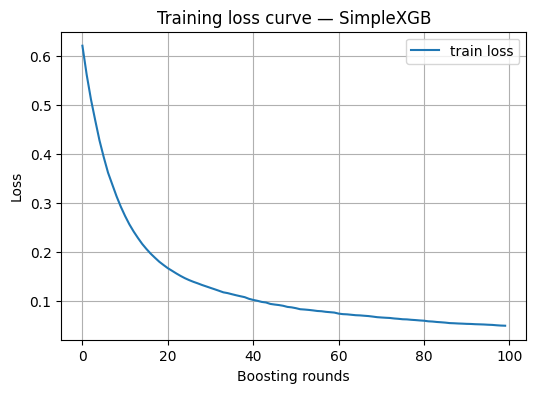

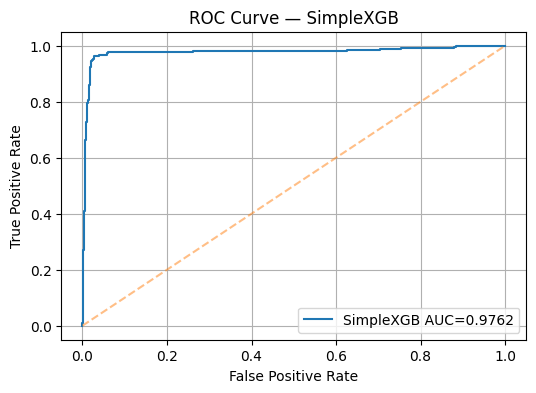

In [7]:
# 14. 📉 Loss curve and ROC for SimpleXGB
plt.figure(figsize=(6,4))
plt.plot(model.train_loss_, label="train loss")
plt.xlabel("Boosting rounds")
plt.ylabel("Loss")
plt.title("Training loss curve — SimpleXGB")
plt.grid(True)
plt.legend()
plt.show()

# ROC
fpr_s, tpr_s, _ = roc_curve(y_test, preds_proba_simple)
plt.figure(figsize=(6,4))
plt.plot(fpr_s, tpr_s, label=f'SimpleXGB AUC={roc_auc_score(y_test, preds_proba_simple):.4f}')
plt.plot([0,1],[0,1], '--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — SimpleXGB")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# 15. ⚖️ Compare SimpleXGB with XGBoost (if xgboost installed)
if has_xgb:
    xgb_auc = roc_auc_score(y_test, preds_proba)
    simple_auc = roc_auc_score(y_test, preds_proba_simple)
    print(f"XGB AUC = {xgb_auc:.4f}, SimpleXGB AUC = {simple_auc:.4f}")
else:
    print("xgboost not installed; comparison skipped.")


xgboost not installed; comparison skipped.


# 16. 🔍 Why the from-scratch approach is correct (brief)
- XGBoost uses a second-order Taylor expansion. For a leaf we set derivative of approximate objective w.r.t leaf weight to zero and derive:
  $$
  w_j^* = - \frac{G_j}{H_j + \lambda}
  $$
- Fitting a tree to targets $z_i = -g_i/h_i$ with sample weights $h_i$ approximates solving that per-leaf optimal weight using weighted least squares.
- Our `SimpleXGB` fits trees to $z$ and updates raw predictions with `learning_rate * tree.predict(X)`, which is the Newton-style step XGBoost uses (simplified).


# 17. 🧰 Practical tips & hyperparameters
- `learning_rate` (eta): smaller values (0.01–0.2) need more trees but reduce overfitting.
- `n_estimators`: number of boosting rounds; pair with `learning_rate`.
- `max_depth`: controls tree complexity; smaller values give simpler trees (3–8 typical).
- `subsample`, `colsample_bytree`: row/column sampling for robustness.
- `lambda` and `gamma` (XGBoost): regularization and minimum loss reduction for a split.
- Early stopping: evaluate on validation set and stop when metric stops improving.


# 18. ⚠️ Limitations & differences from full XGBoost
- `SimpleXGB` here is a **simplified** implementation:
  - We rely on `DecisionTreeRegressor` for splits and do not implement the optimized split search and sparsity-aware algorithms of XGBoost.
  - We don't implement advanced optimizations (histogram splits, column blocks, out-of-core training).
  - Still, the second-order update idea and weighted Newton step are implemented correctly and illustrate the core of XGBoost.


# 19. 🔬 Experiments you can run
- Try varying `learning_rate` and `n_estimators` to see the bias–variance trade-off.
- Replace `DecisionTreeRegressor` with a custom tree learner that exposes leaf indices and compute exact leaf weights using sums of `g` and `h`.
- Add L1 regularization (similar to XGBoost's split/weight pruning logic).
- Try dataset with missing values to explore XGBoost's sparsity handling (our simple version needs explicit imputation).


# 20. ✅ Summary
- XGBoost is an optimized, regularized, second-order gradient boosting framework for decision trees.
- Key idea: use both gradients and Hessians (first + second-order info) and compute closed-form leaf weights.
- The notebook provided:
  - Mathematical foundation and equations.
  - `xgboost` sklearn-style example (visualizations).
  - `SimpleXGB`: a from-scratch, second-order-weighted boosting class that follows the same Newton-style update idea.
- Use this notebook as a foundation — you can extend the `SimpleXGB` to implement more XGBoost features.


